Files already downloaded and verified
Files already downloaded and verified
Is model pruned? False
Predicted:  deer ( 0.9999998807907104 )


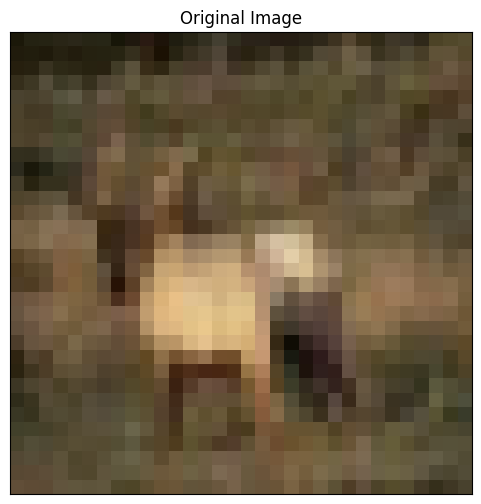

In [1]:
import pickle
import time
import itertools
import numpy as np
from pathlib import Path
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import captum
from captum.attr import visualization as viz
from captum.attr import IntegratedGradients, Saliency, DeepLift, NoiseTunnel


from resnet20 import Resnet_N_W
from Hparams import Hparams
from utils_Earlystopper import EarlyStopper
import utils
import routines

torch.cuda.empty_cache()

try:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
except NameError or ModuleNotFoundError:
    pass
#setting the path to store/load dataset cifar10
workdir = Path.cwd()
data_path = workdir / "datasets" / "cifar10"
if not data_path.exists():
    data_path.mkdir(parents=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_hparams = Hparams.DatasetHparams(
    test_seed=0,
    val_seed=0,
    train_seed=0,
    split_seed=0,
    rngCrop_seed=2,
    rngRandomHflip_seed=0,
    batch_size=128
)
dataloaderhelper = utils.DataLoaderHelper(
    datasethparams=dataset_hparams
)
trainset = dataloaderhelper.get_trainset(data_path, dataloaderhelper.get_transform(False))
testset = dataloaderhelper.get_testset(data_path, dataloaderhelper.get_transform(False))

invTransformation = transforms.Compose([
    transforms.Normalize(
        mean = [0., 0., 0.],
        std = torch.tensor(dataset_hparams.std).pow(-1)
    ),
    transforms.Normalize(
        mean = -torch.tensor(dataset_hparams.mean),
        std = [ 1., 1., 1. ]),
])

def transform_to_matplotlib(img):
    return np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0))

#######################Set up an image#########################
#get image
img, label = trainset[3]
img_orig = invTransformation(img)
img = img.unsqueeze(0) #dummy batch dimension
img.requires_grad = True
img = img.cuda() if torch.cuda.is_available() else img
models, all_model_stats, _1, _2, _3, _4 = routines.load_experiment("e6_1")
winner = models[4]

#remove pruning from winner
list_winner = Resnet_N_W.get_list_of_all_modules(winner)
for module in list_winner:
    if isinstance(module, torch.nn.Linear):
        torch.nn.utils.prune.remove(module, 'weight')
        torch.nn.utils.prune.remove(module, 'bias')
    elif isinstance(module, torch.nn.BatchNorm2d):
        torch.nn.utils.prune.remove(module, 'weight')
        torch.nn.utils.prune.remove(module, 'bias')
    else:
        torch.nn.utils.prune.remove(module, 'weight')

print("Is model pruned?", Resnet_N_W.check_if_pruned(winner))
winner.eval()
#print("Test_acc: ", routines.get_accuracy(device, winner, testloader))
#print("Train_acc: ",routines.get_accuracy(device, winner, trainloader))
#calculate output
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
output = winner(img)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()
predicted_label = classes[int(pred_label_idx.item())]
print('Predicted: ', predicted_label, '(', prediction_score.squeeze().item(), ')')
_ = viz.visualize_image_attr(None, transform_to_matplotlib(img_orig),
                      method="original_image", title="Original Image")

In [2]:
#######################Attribution Methods#########################
#####without noise tunnel#####
#Vanilla gradients
saliency = Saliency(winner)
attributions_grad = saliency.attribute(img, target=pred_label_idx)
attributions_grad_img = transform_to_matplotlib(attributions_grad)
#Integrated gradients
integrated_gradients = IntegratedGradients(winner)
attributions_ig = integrated_gradients.attribute(img, target=pred_label_idx, n_steps=200)
attributions_ig_img = transform_to_matplotlib(attributions_ig)
dl = DeepLift(winner)
attributions_dl = dl.attribute(img, target=pred_label_idx)
attributions_dl_img = transform_to_matplotlib(attributions_dl)

/home/iai/user/theissin/.local/lib/python3.8/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


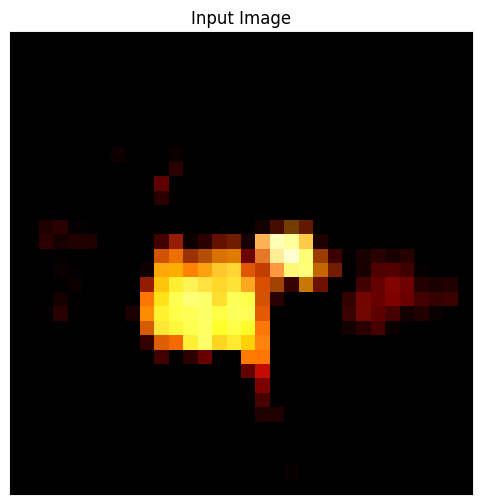

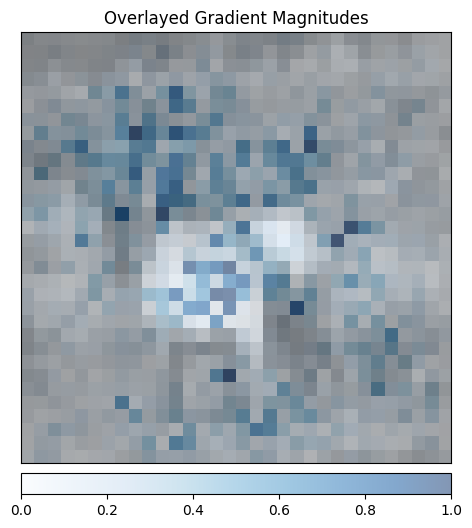

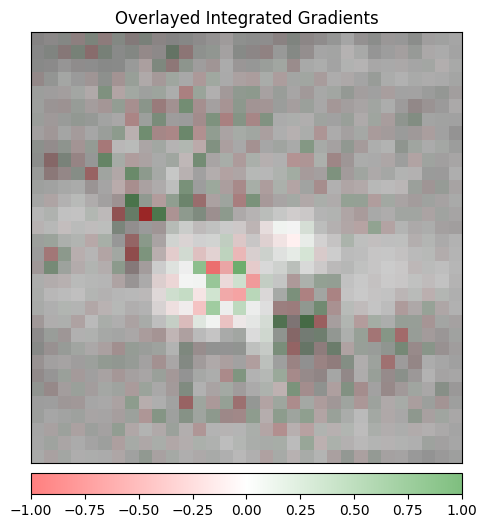

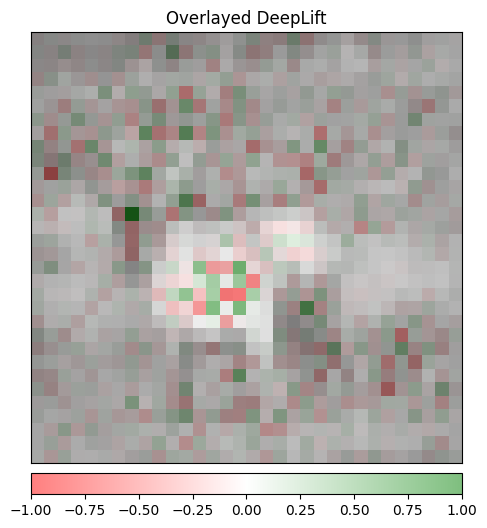

In [3]:
#######################Visualizations#########################
# Show the original image for comparison
input_image = transform_to_matplotlib(img)
_ = viz.visualize_image_attr(None, input_image, 
                      method="original_image", title="Input Image")

_ = viz.visualize_image_attr(attributions_grad_img, input_image,
                            method="blended_heat_map", sign="absolute_value",
                            show_colorbar=True, title="Overlayed Gradient Magnitudes")

_ = viz.visualize_image_attr(attributions_ig_img, input_image,
                            method="blended_heat_map", sign="all",
                            show_colorbar=True, title="Overlayed Integrated Gradients")

_ = viz.visualize_image_attr(attributions_dl_img, input_image,
                            method="blended_heat_map", sign="all",
                            show_colorbar=True, title="Overlayed DeepLift")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


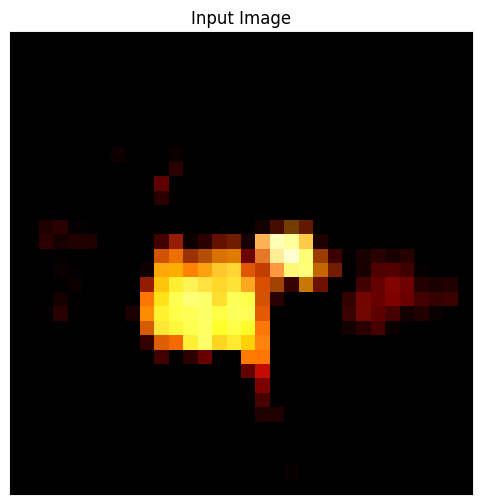

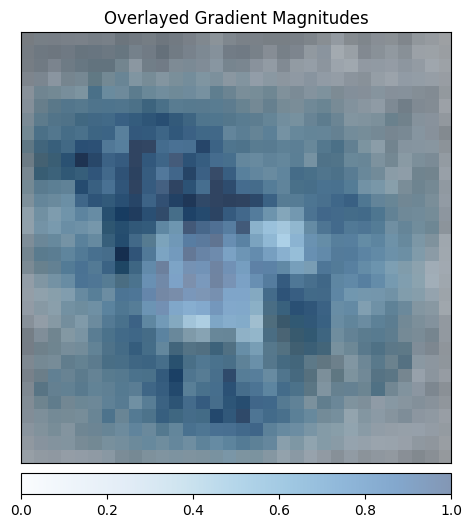

In [4]:
#####with noise tunnel#####
grad = Saliency(winner)
nt_grad = NoiseTunnel(grad)
attr_grad_nt = nt_grad.attribute(img, target=pred_label_idx,
                                nt_type='smoothgrad',
                                nt_samples=100, stdevs=0.2)
attr_grad_nt_img = transform_to_matplotlib(attr_grad_nt)

input_image = transform_to_matplotlib(img)
_ = viz.visualize_image_attr(None, input_image, 
                      method="original_image", title="Input Image")

_ = viz.visualize_image_attr(attr_grad_nt_img, input_image,
                            method="blended_heat_map", sign="absolute_value",
                            show_colorbar=True, title="Overlayed Gradient Magnitudes")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


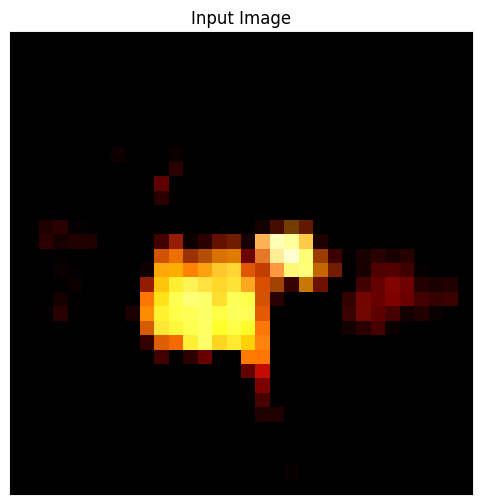

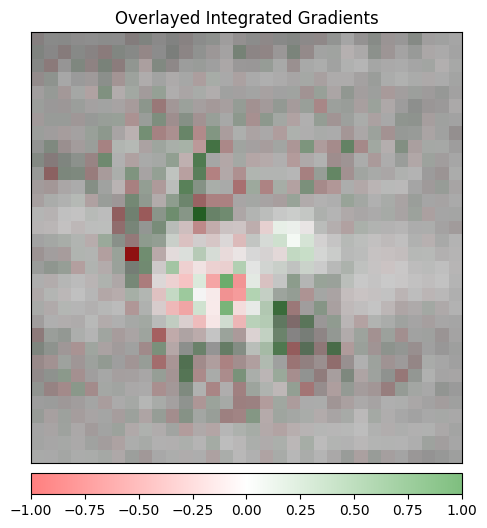

In [5]:
ig = IntegratedGradients(winner)
nt_ig = NoiseTunnel(ig)
attr_ig_nt = nt_ig.attribute(img, target=pred_label_idx,
                            baselines=img * 0, nt_type='smoothgrad',
                            nt_samples=40, stdevs=0.2, n_steps=40)
attr_ig_nt_img = transform_to_matplotlib(attr_ig_nt)

input_image = transform_to_matplotlib(img)
_ = viz.visualize_image_attr(None, input_image, 
                      method="original_image", title="Input Image")

_ = viz.visualize_image_attr(attr_ig_nt_img, input_image,
                            method="blended_heat_map", sign="all",
                            show_colorbar=True, title="Overlayed Integrated Gradients")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


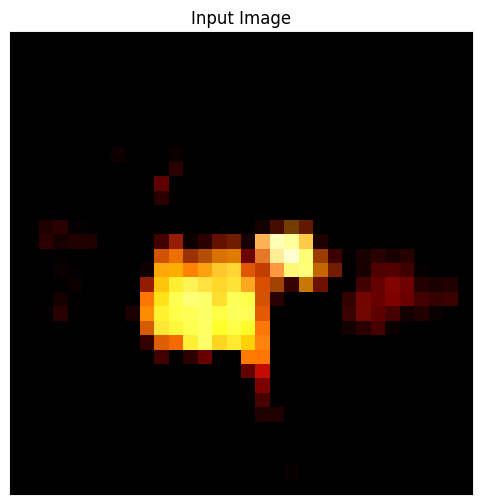

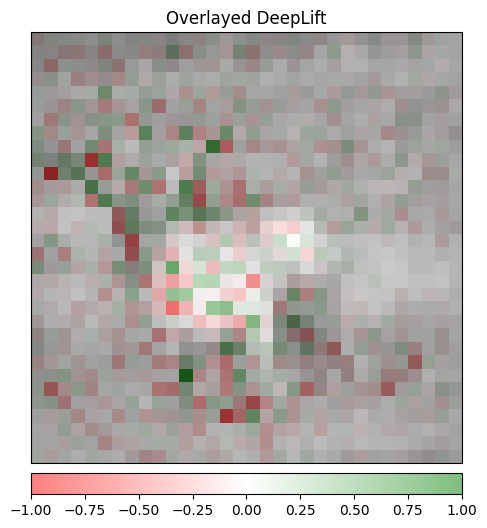

In [6]:
dl = DeepLift(winner)
nt_dl = NoiseTunnel(dl)
attr_dl_nt = nt_dl.attribute(img, target=pred_label_idx,
                            baselines=img * 0, nt_type='smoothgrad',
                            nt_samples=100, stdevs=0.2)
attr_dl_nt_img = transform_to_matplotlib(attr_dl_nt)


input_image = transform_to_matplotlib(img)
_ = viz.visualize_image_attr(None, input_image, 
                      method="original_image", title="Input Image")

_ = viz.visualize_image_attr(attr_dl_nt_img, input_image,
                            method="blended_heat_map", sign="all",
                            show_colorbar=True, title="Overlayed DeepLift")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


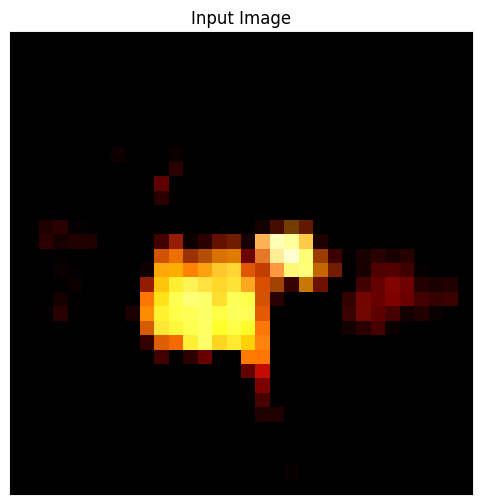

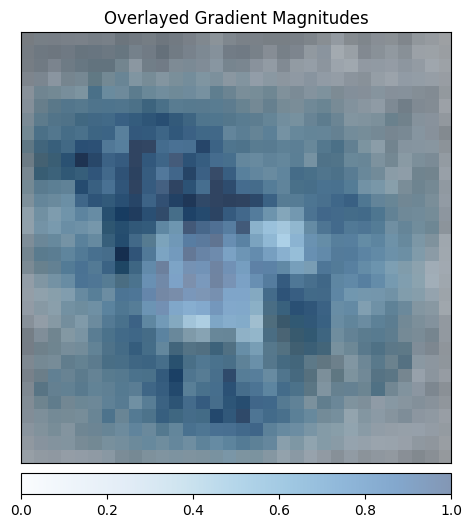

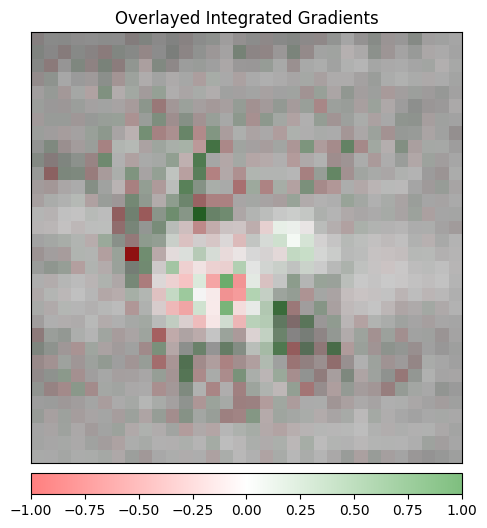

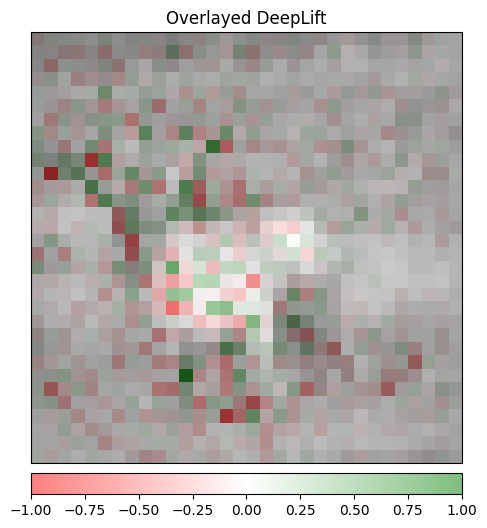

In [7]:
#######################Visualizations#########################
# Show the original image for comparison
input_image = transform_to_matplotlib(img)
_ = viz.visualize_image_attr(None, input_image, 
                      method="original_image", title="Input Image")

_ = viz.visualize_image_attr(attr_grad_nt_img, input_image,
                            method="blended_heat_map", sign="absolute_value",
                            show_colorbar=True, title="Overlayed Gradient Magnitudes")

_ = viz.visualize_image_attr(attr_ig_nt_img, input_image,
                            method="blended_heat_map", sign="all",
                            show_colorbar=True, title="Overlayed Integrated Gradients")

_ = viz.visualize_image_attr(attr_dl_nt_img, input_image,
                            method="blended_heat_map", sign="all",
                            show_colorbar=True, title="Overlayed DeepLift")